# 1. Fourier Spectral Grid

In [1]:
import numpy as np
from numpy import pi, abs, max, cos, sin, tan, exp

from numpy.linalg import inv
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

In [2]:
N = 16 # Terrible things will happen if N is an odd number.

row = np.arange(N)[:, None]
col = np.arange(N)[None, :]

def aliased_index(k, N):
    return k - N * (k >= (N + 1)//2)

spectral_grid  = 2 * pi * row / N
dense_grid     = np.linspace(0, 2*pi, 1000)[:, None]

spectral_basis = exp(1j * aliased_index(col, N) * spectral_grid)
dense_basis    = exp(1j * aliased_index(col, N) * dense_grid)

if N % 2 == 0:                                          #Here we remove the imaginary part of the Nyquist mode.
    dense_basis[:, N//2] = dense_basis[:, N//2].real    #This is equivalent to Trefethen's trick in page 19.

## 1.1 Aliasing and the Nyquist frequency

Some text here


Frequencies on the grid: [ 0  1  2  3  4  5  6  7 -8 -7 -6 -5 -4 -3 -2 -1].



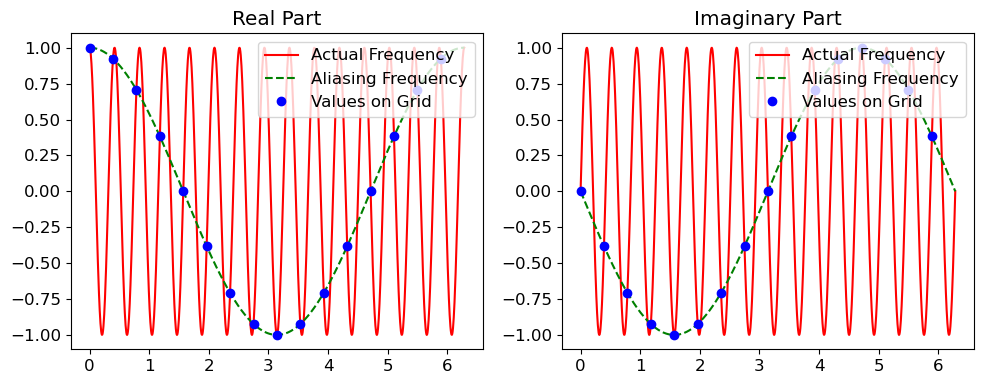

In [12]:
n = 15    # Try values at the Nyquist frequency N//2 and higher.

print(f'\nFrequencies on the grid: {aliased_index(np.arange(N), N)}.\n')

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].set_title('Real Part')
ax[0].plot(dense_grid, exp(1j * n * dense_grid).real, 'r-', label = 'Actual Frequency')
ax[0].plot(dense_grid, dense_basis[:, n].real, 'g--', label = 'Aliasing Frequency')
ax[0].plot(spectral_grid, spectral_basis[:, n].real, 'bo', label = 'Values on Grid')
ax[0].legend(loc = 'upper right')
ax[0].set_ylim(-1.1, 1.1)

ax[1].set_title('Imaginary Part')
ax[1].plot(dense_grid, exp(1j * n * dense_grid).imag, 'r-', label = 'Actual Frequency')
ax[1].plot(dense_grid, dense_basis[:, n].imag, 'g--', label = 'Aliasing Frequency')
ax[1].plot(spectral_grid, spectral_basis[:, n].imag, 'bo', label = 'Values on Grid')
ax[1].legend(loc = 'upper right')
ax[1].set_ylim(-1.1, 1.1)

plt.tight_layout()
################################################################################

## 1.2 A very inefficient FFT

We can test that the inverse_spectral_basis matrix (multiplied by N) produces the same result as the FFT when multiplied by a function vector. 

In a much less efficient way than the FFT algorithm, though.

In [4]:
def is_the_same(A, B):
    return max(abs(A - B)) < 1e-10

spectral_basis_inv = inv(spectral_basis)
f = exp(sin(spectral_grid))

actual_FFT = fft(f.flatten())
matrix_FFT = N * (spectral_basis_inv @ f).flatten()
is_the_same(actual_FFT, matrix_FFT)

True

## 1.3 The cardinal functions

True


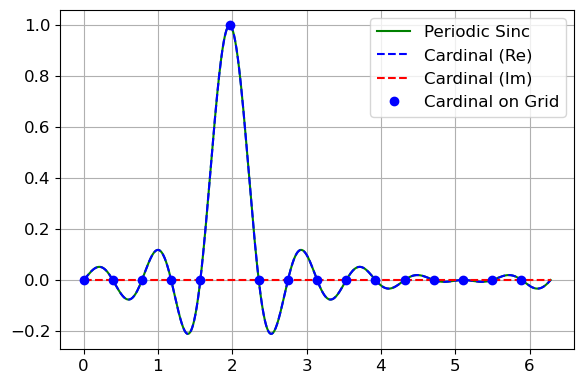

In [5]:
n = 5

def sinc(x, N):
    return (x == 0) + sin(N * x / 2) / (N * tan(x / 2) + (x == 0))

spectral_cardinals = np.eye(N)
dense_cardinals    = dense_basis @ spectral_basis_inv

print(is_the_same(sinc(dense_grid - spectral_grid[n], N), dense_cardinals[:, [n]]))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid,    sinc(dense_grid - spectral_grid[n], N), color = 'green', label = 'Periodic Sinc')
ax.plot(dense_grid,    dense_cardinals[:, n].real, 'b--', label = 'Cardinal (Re)')
ax.plot(dense_grid,    dense_cardinals[:, n].imag, 'r--', label = 'Cardinal (Im)')
ax.plot(spectral_grid, spectral_cardinals[:, n], 'bo', label = 'Cardinal on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()
################################################################################

True


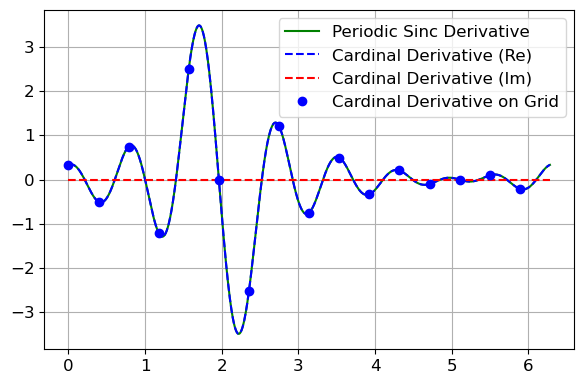

In [6]:
n = 5

def sinc_diff(x, N):
    return 0.5 * cos(N * x / 2) / (tan(x / 2) + (x == 0)) - sin(N * x / 2) / (2 * N * sin(x / 2)**2 + (x == 0))

spectral_basis_diff   = 1j * aliased_index(col, N) * exp(1j * aliased_index(col, N) * spectral_grid)
dense_basis_diff      = 1j * aliased_index(col, N) * exp(1j * aliased_index(col, N) * dense_grid)

if N % 2 == 0:                                                          #Here we remove the imaginary part of the Nyquist mode.
    spectral_basis_diff[:, N//2] = spectral_basis_diff[:, N//2].real    #This is equivalent to Trefethen's trick in page 19.
    dense_basis_diff[:, N//2]    = dense_basis_diff[:, N//2].real    

diff_matrix          = spectral_basis_diff @ spectral_basis_inv
dense_cardinals_diff = dense_basis_diff @ spectral_basis_inv

print(is_the_same(sinc_diff(dense_grid - spectral_grid[n], N), dense_cardinals_diff[:, [n]]))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid,    sinc_diff(dense_grid - spectral_grid[n], N), color = 'green', label = 'Periodic Sinc Derivative')
ax.plot(dense_grid,    dense_cardinals_diff[:, n].real, 'b--', label = 'Cardinal Derivative (Re)')
ax.plot(dense_grid,    dense_cardinals_diff[:, n].imag, 'r--', label = 'Cardinal Derivative (Im)')
ax.plot(spectral_grid, diff_matrix[:, n].real, 'bo',   label = 'Cardinal Derivative on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()
################################################################################

## 1.4 Fourier Differentiation Matrices and Interpolation

In [13]:
def FourierD(N):
    row = np.arange(N)[:, None]
    col = np.arange(N)[None, :]
    x = 2 * pi * row / N
    D = (row != col) * 0.5 * (-1)**(row + col) / tan(0.5 * (x[row, 0] - x[col, 0]) + (row == col))
    return x, D

x, D = FourierD(N)
is_the_same(D, diff_matrix)

True

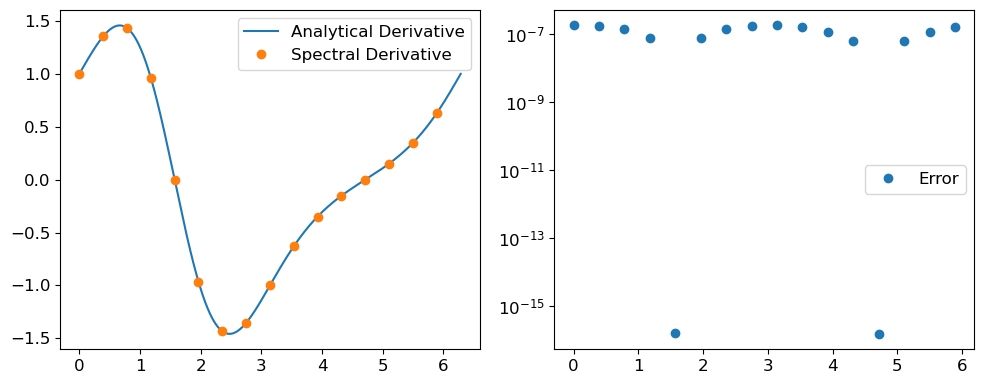

In [8]:
f  = exp(sin(x))
df = cos(x) * exp(sin(x))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals.real @ df, label = 'Analytical Derivative')
ax[0].plot(x, D @ f, 'o', label = 'Spectral Derivative')
ax[0].legend(loc = 'upper right')

ax[1].set_yscale('log')
ax[1].plot(x, abs(D @ f - df), 'o', label = 'Error')
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################

## 1.5 FFT Differentiation


The frequencies we are considering are: [ 0  1  2  3  4  5  6  7  0 -7 -6 -5 -4 -3 -2 -1].
Notice we have removed the asymetric Nyquist mode.



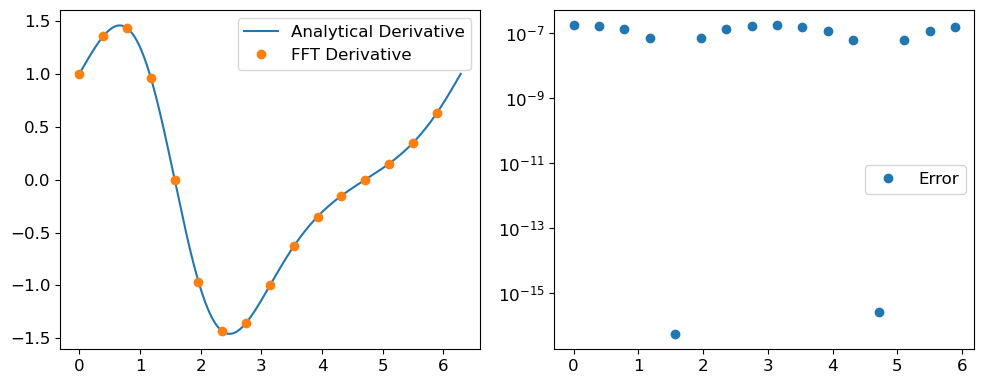

In [9]:
f  = exp(sin(x))
df = cos(x) * exp(sin(x))

freqs = aliased_index(np.arange(N), N) 

if N % 2 == 0:         #Here we kill the derivative of the Nyquist mode.
    freqs[N//2] = 0    #This is equivalent to Trefethen's trick in page 23.
    
print(f'\nThe frequencies we are considering are: {freqs}.')
print(f'Notice we have removed the asymetric Nyquist mode.\n')

FFT_df = ifft(1j * freqs * fft(f.flatten())).real

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals.real @ df, label = 'Analytical Derivative')
ax[0].plot(x, FFT_df, 'o', label = 'FFT Derivative')
ax[0].legend(loc = 'upper right')

ax[1].set_yscale('log')
ax[1].plot(x, abs(FFT_df - df.flatten()), 'o', label = 'Error')
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################

## 1.6 Integration

In [10]:
abs(np.mean(spectral_basis, axis = 0))

array([1.00000000e+00, 3.53815554e-17, 4.90653893e-17, 3.97459940e-16,
       3.85786410e-16, 3.18074688e-16, 3.68807270e-16, 2.18464989e-16,
       2.83276945e-16, 2.18464989e-16, 3.68807270e-16, 3.18074688e-16,
       3.85786410e-16, 3.97459940e-16, 4.90653893e-17, 3.53815554e-17])

In [14]:
CorrectIntegral       = 7.9549265210128452728
TrapezoidRuleIntegral = 2 * pi * np.mean(f)

is_the_same(correct_int, spectral_int)

True